In [1]:
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()


True

In [2]:
RESEARCH_DATA = os.environ.get("RESEARCH_DATA")

EL = "attempt_1"
PID = "Lang"

SBFL_FORMULA = [
    "tarantula", "ochiai", "dstar",
    "naish1", "naish2", "gp13"
]

TRANSITION_TYPES = {
    "type1": "result_transition",
    "type2": "exception_type_transition",
    "type3": "exception_msg_transition",
    "type4": "stacktrace_transition"
}

MUT_RANGE = (1, 11)

TOP_N = [1, 3, 5]

In [3]:
# Faulty lines are indicated with 'fault_line' as value 1.

# res = {bid: {std: [rank of faulty_line: 1, rank of faulty_line: 2, ...] ...} ...}
# std are the sbfl formulas and mbfl formulas in TRANSITION_TYPES and MUT_RANGE

def set_faulty_line_ranks(total_results, lineIdx2lineData, bid):
    total_results[bid] = {}

    for sbfl_form in SBFL_FORMULA:
        for lineIdx, lineData in lineIdx2lineData.items():
            fault_line = lineData.get("fault_line")
            if fault_line == 1:
                sbfl_key = f"{sbfl_form}_rank"
                rank = lineData.get(sbfl_key)
                if sbfl_key not in total_results[bid]:
                    total_results[bid][sbfl_key] = []
                total_results[bid][sbfl_key].append(rank)
    
    for mut_cnt in range(MUT_RANGE[0], MUT_RANGE[1]):
        for transition_type, transition_key in TRANSITION_TYPES.items():
            for lineIdx, lineData in lineIdx2lineData.items():
                fault_line = lineData.get("fault_line")
                if fault_line == 1:
                    muse_key = f"mutCnt{mut_cnt}_{transition_key}_final_muse_score_rank"
                    muse_rank = lineData.get(muse_key)
                    if muse_key not in total_results[bid]:
                        total_results[bid][muse_key] = []
                    total_results[bid][muse_key].append(muse_rank)
                    

                    metal_key = f"mutCnt{mut_cnt}_{transition_key}_final_metal_score_rank"
                    metal_rank = lineData.get(metal_key)
                    if metal_key not in total_results[bid]:
                        total_results[bid][metal_key] = []
                    total_results[bid][metal_key].append(metal_rank)

In [4]:
total_results = {}

lineIdx2lineDataDir = os.path.join(RESEARCH_DATA, EL, PID)

for bid_res_file in os.listdir(lineIdx2lineDataDir):
    pck_file = os.path.join(lineIdx2lineDataDir, bid_res_file)
    with open(pck_file, 'rb') as f:
        bid = int(bid_res_file.split("_")[0])
        lineIdx2lineData = pickle.load(f)
        set_faulty_line_ranks(total_results, lineIdx2lineData, bid)

with open(os.path.join(RESEARCH_DATA, EL, f"{PID}_faulty_line_ranks.json"), 'w') as f:
    json.dump(total_results, f, indent=4)

In [9]:
# TOP-N: # of faults where at least one its faulty statement is located within top-N. (Top-1, Top-3, and Top-5).
# MFR: average of ranks of the first faulty statement for all faults
# MAR: average rank of all faulty statements for each faults

def return_results(ranks):
    topN = {n: sum(1 for rank in ranks if rank <= n) for n in TOP_N}
    mfr = min(ranks)
    mar = copy.deepcopy(ranks)

    return {
        "topN": topN,
        "mfr": mfr,
        "mar_list": mar
    }

def calculate_exp_results(total_results):
    default = {
        "topN": {n: 0 for n in TOP_N},
        "mfr_list": [],
        "mar_list": []
    }

    exp_results = {}
    for sbfl_form in SBFL_FORMULA:
        sbfl_key = f"{sbfl_form}_rank"
        exp_results[sbfl_key] = copy.deepcopy(default)

        for bid, result in total_results.items():
            ranks = result.get(sbfl_key)

            # Update TOP-N counts
            for n in TOP_N:
                if any(rank <= n for rank in ranks):
                    exp_results[sbfl_key]["topN"][n] += 1

            # Update MFR and MAR
            exp_results[sbfl_key]["mfr_list"].append(min(ranks))
            exp_results[sbfl_key]["mar_list"].extend(ranks)
    

    for mut_cnt in range(MUT_RANGE[0], MUT_RANGE[1]):
        for transition_type, transition_key in TRANSITION_TYPES.items():
            muse_key = f"mutCnt{mut_cnt}_{transition_key}_final_muse_score_rank"
            exp_results[muse_key] = copy.deepcopy(default)

            metal_key = f"mutCnt{mut_cnt}_{transition_key}_final_metal_score_rank"
            exp_results[metal_key] = copy.deepcopy(default)

            for bid, result in total_results.items():
                muse_ranks = result.get(muse_key)
                metal_ranks = result.get(metal_key)

                # Update TOP-N counts
                for n in TOP_N:
                    if any(rank <= n for rank in muse_ranks):
                        exp_results[muse_key]["topN"][n] += 1
                    if any(rank <= n for rank in metal_ranks):
                        exp_results[metal_key]["topN"][n] += 1

                # Update MFR and MAR
                exp_results[muse_key]["mfr_list"].append(min(muse_ranks))
                exp_results[muse_key]["mar_list"].extend(muse_ranks)
                exp_results[metal_key]["mfr_list"].append(min(metal_ranks))
                exp_results[metal_key]["mar_list"].extend(metal_ranks)
    
    for key, result in exp_results.items():
        result["mfr"] = sum(result["mfr_list"]) / len(result["mfr_list"])
        result["mar"] = sum(result["mar_list"]) / len(result["mar_list"])

    return exp_results

def show_results(exp_results):
    showing_results = {}
    for key, result in exp_results.items():
        print(f"Results for {key}:")
        for n in TOP_N:
            print(f"  Top-{n}: {result['topN'][n]}")
        
        MFR = result["mfr"]
        MAR = result["mar"]

        if key in ["mutCnt10_result_transition_final_muse_score_rank", "mutCnt10_result_transition_final_metal_score_rank", "ochiai_rank", "naish2_rank"]:
            showing_results[key] = {
                "mfr_list": result['mfr_list'],
                "mar_list": result['mar_list'],
                "topN": result['topN'],
                "mfr": MFR,
                "mar": MAR
            }

        print(f"  MFR: {MFR}")
        print(f"  MAR: {MAR}")
        print("\n")

    print(json.dumps(showing_results, indent=4))

def save_to_csv(exp_results):
    data = []
    for key, result in exp_results.items():
        row = {
            "Techniques": key,
            "Top-1": result['topN'][1],
            "Top-3": result['topN'][3],
            "Top-5": result['topN'][5],
            "MFR": result["mfr"],
            "MAR": result["mar"]
        }
        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(os.path.join(RESEARCH_DATA, EL, f"{PID}_experimental_results.csv"), index=False)

In [ ]:
exp_results = calculate_exp_results(total_results)
# show_results(exp_results)
save_to_csv(exp_results)

Results for tarantula_rank:
  Top-1: 0
  Top-3: 0
  Top-5: 2
  MFR: 61.98360655737705
  MAR: 75.38853503184713


Results for ochiai_rank:
  Top-1: 3
  Top-3: 6
  Top-5: 15
  MFR: 28.918032786885245
  MAR: 41.738853503184714


Results for dstar_rank:
  Top-1: 1
  Top-3: 1
  Top-5: 3
  MFR: 44.75409836065574
  MAR: 63.00636942675159


Results for naish1_rank:
  Top-1: 3
  Top-3: 6
  Top-5: 14
  MFR: 27.311475409836067
  MAR: 48.961783439490446


Results for naish2_rank:
  Top-1: 3
  Top-3: 6
  Top-5: 14
  MFR: 25.721311475409838
  MAR: 44.99363057324841


Results for gp13_rank:
  Top-1: 3
  Top-3: 6
  Top-5: 14
  MFR: 25.721311475409838
  MAR: 44.99363057324841


Results for mutCnt1_result_transition_final_muse_score_rank:
  Top-1: 3
  Top-3: 5
  Top-5: 7
  MFR: 44.63934426229508
  MAR: 56.681528662420384


Results for mutCnt1_result_transition_final_metal_score_rank:
  Top-1: 2
  Top-3: 3
  Top-5: 5
  MFR: 55.63934426229508
  MAR: 71.18471337579618


Results for mutCnt1_exception_type_t

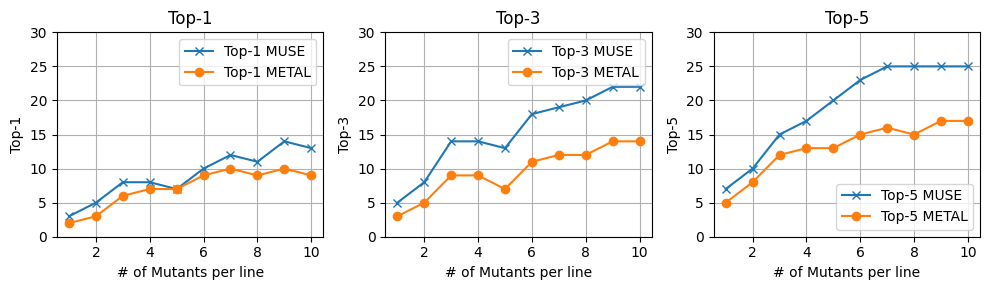

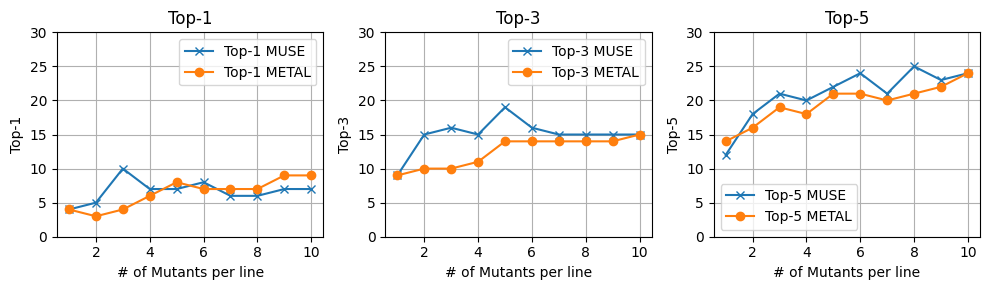

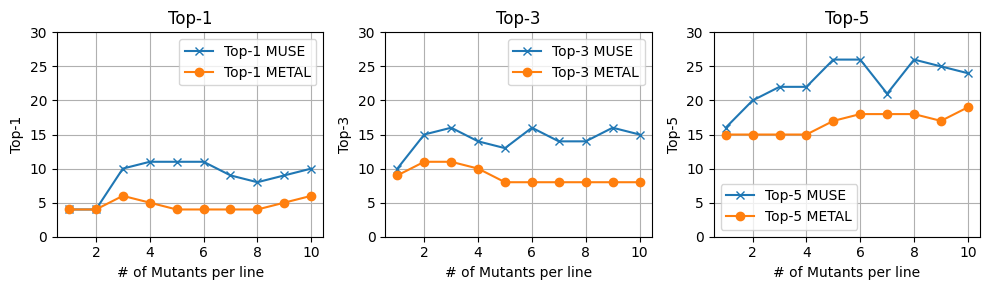

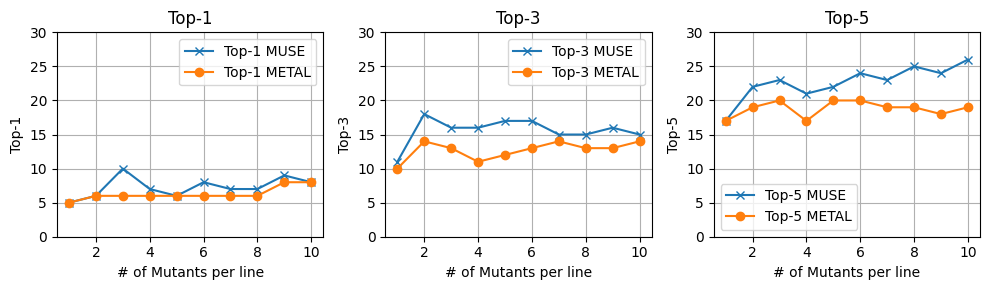

In [16]:
def get_mut_cnt_results(exp_results, transition_type, technique="muse"):
    results = {
        "topN_list": {n: [] for n in TOP_N},
        "mfr_list": [],
        "mar_list": []
    }

    for mut_cnt in range(MUT_RANGE[0], MUT_RANGE[1]):
        key = f"mutCnt{mut_cnt}_{TRANSITION_TYPES[transition_type]}_final_{technique}_score_rank"
        
        topN = exp_results[key]["topN"]
        mfr = exp_results[key]["mfr"]
        mar = exp_results[key]["mar"]

        for n in TOP_N:
            results["topN_list"][n].append(topN[n])
        results["mfr_list"].append(mfr)
        results["mar_list"].append(mar)

    return results

def plot_graphs(exp_results):
    # plot line graphs for top-N for each type
    # x-axis is the number of mut_cnt
    # y-axis is top-N
    # for each muse score and metal score on on different graphs
    for transition_type, transition_key in TRANSITION_TYPES.items():
        plt.figure(figsize=(10, 3))

        res = get_mut_cnt_results(exp_results, transition_type, technique="muse")
        muse_topN_list = res["topN_list"]
        muse_mfr_list = res["mfr_list"]
        muse_mar_list = res["mar_list"]

        res = get_mut_cnt_results(exp_results, transition_type, technique="metal")
        metal_topN_list = res["topN_list"]
        metal_mfr_list = res["mfr_list"]
        metal_mar_list = res["mar_list"]

        # One graph only for Top-N
        # another graph for MFR
        # another graph for MAR
        plt.subplot(1, 3, 1)
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), muse_topN_list[1], label='Top-1 MUSE', marker='x')
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), metal_topN_list[1], label='Top-1 METAL', marker='o')
        plt.ylim(0, 30)
        plt.title(f'Top-1')
        plt.xlabel('# of Mutants per line')
        plt.ylabel('Top-1')
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), muse_topN_list[3], label='Top-3 MUSE', marker='x')
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), metal_topN_list[3], label='Top-3 METAL', marker='o')
        plt.ylim(0, 30)
        plt.title(f'Top-3')
        plt.xlabel('# of Mutants per line')
        plt.ylabel('Top-3')
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), muse_topN_list[5], label='Top-5 MUSE', marker='x')
        plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), metal_topN_list[5], label='Top-5 METAL', marker='o')
        plt.ylim(0, 30)
        plt.title(f'Top-5')
        plt.xlabel('# of Mutants per line')
        plt.ylabel('Top-5')
        plt.legend()
        plt.grid()

        # plt.subplot(3, 3, 4)
        # plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), muse_mfr_list, label='MFR MUSE', marker='x')
        # plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), metal_mfr_list, label='MFR METAL', marker='o')
        # plt.title(f'MFR ({transition_type})')
        # plt.xlabel('Mutant Count')
        # plt.ylabel('MFR')
        # plt.legend()
        # plt.grid()

        # plt.subplot(3, 3, 5)
        # plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), muse_mar_list, label='MAR MUSE', marker='x')
        # plt.plot(range(MUT_RANGE[0], MUT_RANGE[1]), metal_mar_list, label='MAR METAL', marker='o')
        # plt.title(f'MAR ({transition_type})')
        # plt.xlabel('Mutant Count')
        # plt.ylabel('MAR')
        # plt.legend()
        # plt.grid()

        plt.tight_layout()
        plt.show()

# Example usage
plot_graphs(exp_results)

In [8]:
#